In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path().resolve().parent.parent
DIR_PATH = Path().resolve()
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))

In [3]:
from glob import glob
import numpy as np
import scipy
import matplotlib.pyplot as plt
import PyPDF2
import soundfile as sf
from frequency_response import FrequencyResponse
from biquad import digital_coeffs, peaking
from research.limited_gradient_smoothing.utils import log_log_gradient

## Frequency Response Creation Utils

In [4]:
def iir_fr(fc, Q, gain):
    fs = 48000
    fr = FrequencyResponse(name='peaking')
    fr.raw = np.zeros(fr.frequency.shape)
    for __fc, __Q, __gain in zip(fc, Q, gain):
        a0, a1, a2, b0, b1, b2 = peaking(__fc, __Q, __gain, fs=fs)
        fr.raw += digital_coeffs(fr.frequency, fs, a0, a1, a2, b0, b1, b2)
    return fr

def equalization(measurement_path, target_path):
    fr = FrequencyResponse.read_from_csv(measurement_path)
    target = FrequencyResponse.read_from_csv(target_path)
    fr.compensate(target)
    fr.raw = -fr.error
    fr.reset()
    return fr

def write_ir(fr):
    ir = fr.minimum_phase_impulse_response(fs=48000, f_res=10, normalize=True)
    DIR_PATH.joinpath('ir').mkdir(exist_ok=True)
    sf.write(
        DIR_PATH.joinpath('ir', f'{fr.name}.wav'),
        np.tile(ir, (2, 1)).T,
        48000, 'PCM_16'
    )

## Limited Delta Algorith
This algorithm avoids peaks by limiting the delta (derivative) of a function.
Curve is traversed in both directions, gradients are limited and a minimum is taken.
Gradient limit regions which don't overlap with the opposite direction regions are discarded.

#### TODO
- 2nd round, one way clipping disabled: there must be a opposite direction clip region beyond (overlapping) the current region ???
- 25% of max gradient between 8 kHz and 10 kHz ???
- Backward start index requirements are relaxed with heavily smoothed +10 kHz region ???
- Fix trend by comparing super heavy smoothed EQ FRs ???

In [11]:
def limited_forward_delta(x, y, limit, start_index=0):
    limited = []
    clipped = []
    for i in range(len(x)):
        if i <= start_index:
            limited.append(y[i])
            clipped.append(False)
            continue
        gradient = log_log_gradient(x[i], x[i - 1], y[i], limited[-1])
        local_limit = limit / 4 if 8000 <= x[i] <= 10000 else limit
        if gradient > local_limit:
            gradient = local_limit
            clipped.append(True)
        else:
            clipped.append(False)
        octaves = np.log(x[i] / x[i - 1]) / np.log(2)
        limited.append(limited[-1] + gradient * octaves)
    return np.array(limited), np.array(clipped)

def limited_delta_plots(fr, limit):
    fr.smoothen_fractional_octave(window_size=1/12, treble_window_size=2, treble_f_lower=9000, treble_f_upper=12000)
    
    x = fr.frequency.copy()
    #y = fr.raw.copy()
    y = fr.smoothed.copy()
    peaks, _ = scipy.signal.find_peaks(y, prominence=1)
    negative_peaks, _ = scipy.signal.find_peaks(-y, prominence=1)
    
    # Find starting index for the backward pass
    if peaks[-1] > negative_peaks[-1]:
        # Last peak is a positive peak
        # Find index on the right side of the peak where the curve crosses the left side minimum
        y[negative_peaks[-1]]
        backward_start = np.argwhere(y[peaks[-1]:] <= y[negative_peaks[-1]])
        if len(backward_start):
            backward_start = len(y) - (backward_start[0, 0] + peaks[-1]) - 1
        else:
            backward_start = 0
    else:
        # Last peak is a negative peak, start there
        backward_start = len(y) - negative_peaks[-1] - 1
    bws_ind = len(y) - backward_start - 1
    
    limited_forward, clipped_forward = limited_forward_delta(x, y, limit, start_index=0)
    limited_backward, clipped_backward = limited_forward_delta(x, np.flip(y), limit, start_index=backward_start)
    limited_backward = np.flip(limited_backward)
    clipped_backward = np.flip(clipped_backward)
        
    limiter = FrequencyResponse(
        name='limiter', frequency=x.copy(), raw=np.min(np.vstack([limited_forward, limited_backward]), axis=0))
    limiter.smoothen_fractional_octave(window_size=1 / 3, treble_window_size=1 / 3)
    limited = limiter.smoothed

    fig, ax = fr.plot_graph(show=False, raw_plot_kwargs={'color': 'C2'}, smoothed_plot_kwargs={'color': 'C2', 'linewidth': 1, 'linestyle': 'dashed'})
    fig.set_size_inches(20, 9)
    ax.plot(x, limited, label='Limited', color='C1')
    ax.fill_between(x, clipped_forward * -5, clipped_forward * 10, label='Clipped left to right', color='blue', alpha=0.1)
    ax.fill_between(x, clipped_backward * -10, clipped_backward * 5, label='Clipped right to left', color='red', alpha=0.1)
    ax.scatter(x[peaks], y[peaks], color='red')
    ax.scatter(x[negative_peaks], y[negative_peaks], color='blue')
    ax.scatter(x[bws_ind], y[bws_ind], 300, marker='X', color='magenta', alpha=0.4)
    ax.legend()
    #ax.set_xlim([1000, 20000])
    
    #fr.equalization = fr.smoothed
    #write_ir(fr)
    #fr.equalization = limited
    #fr.name += ' limited'
    #write_ir(fr)
    
    DIR_PATH.joinpath('img').mkdir(exist_ok=True)
    fig.savefig(DIR_PATH.joinpath('img', f'{fr.name}.png'))
    plt.show()
    plt.close(fig)

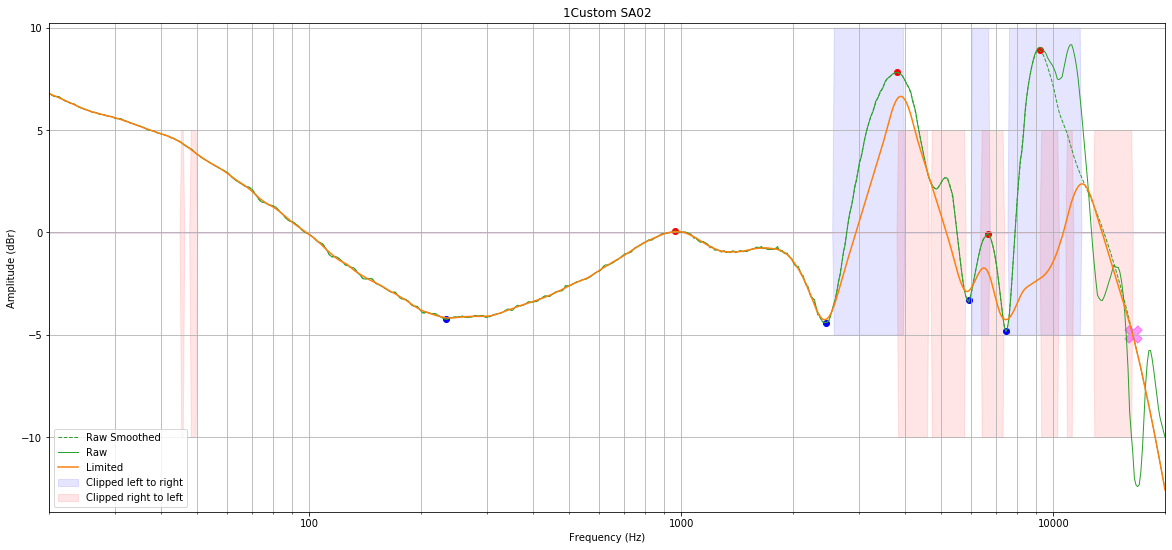

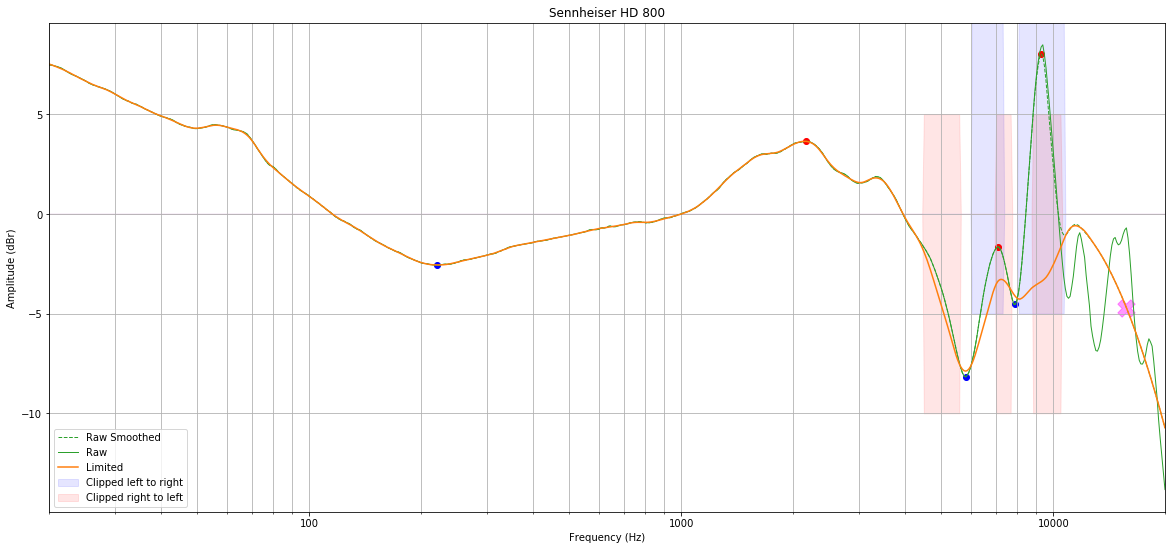

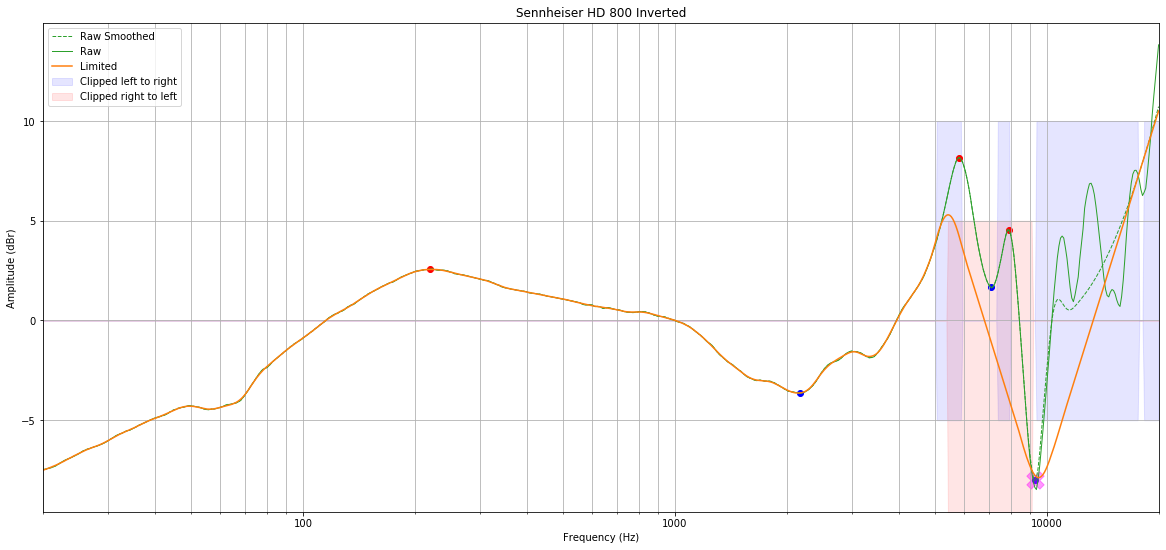

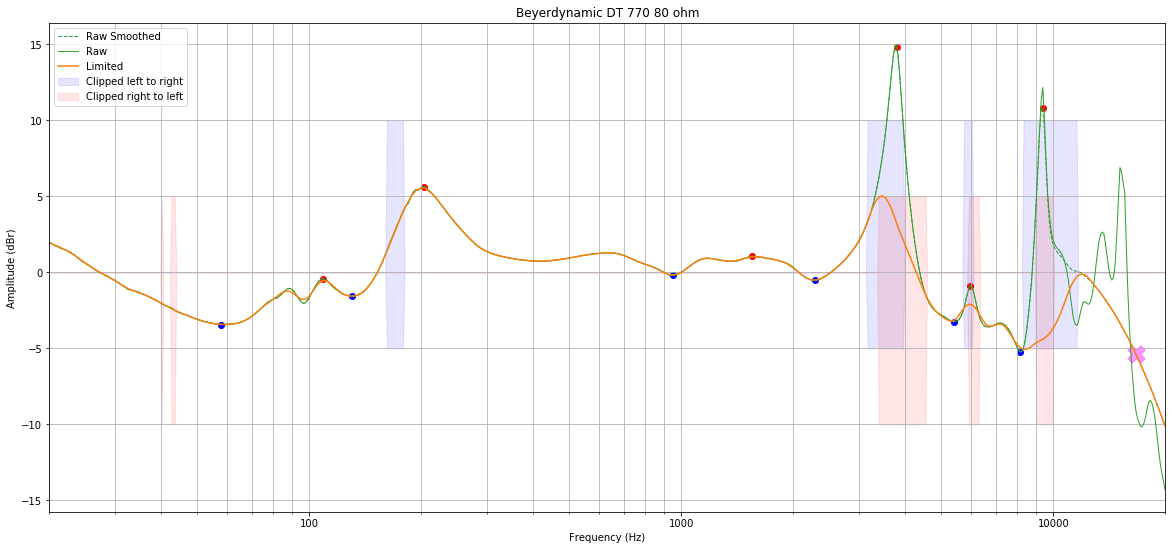

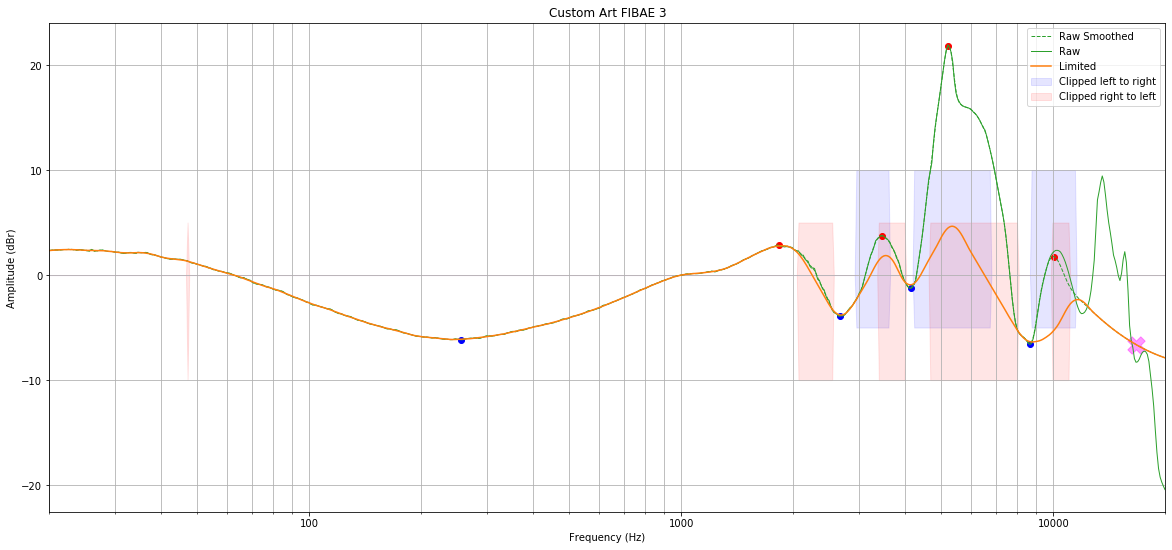

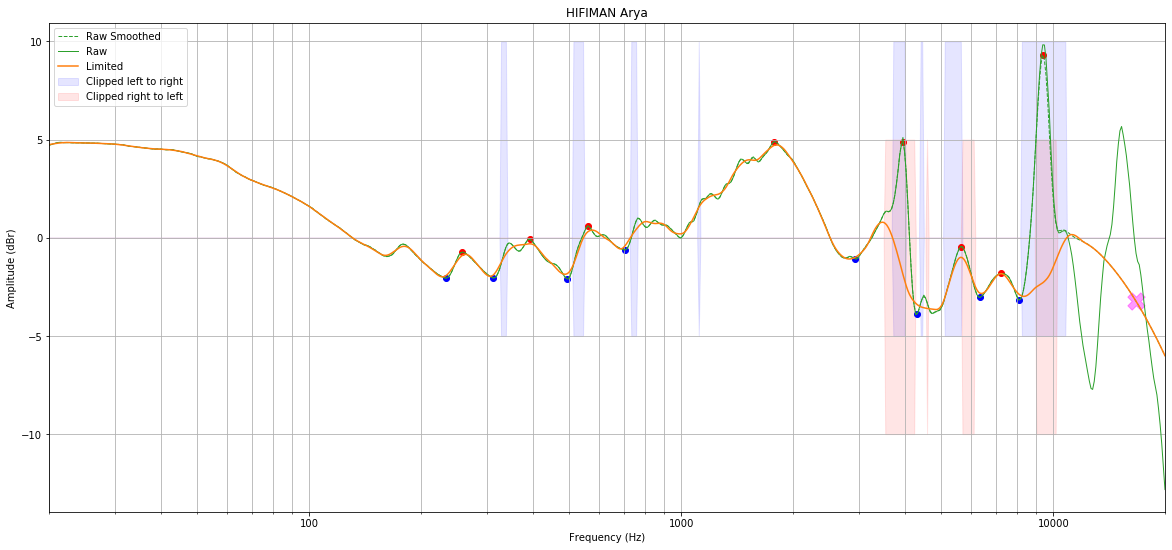

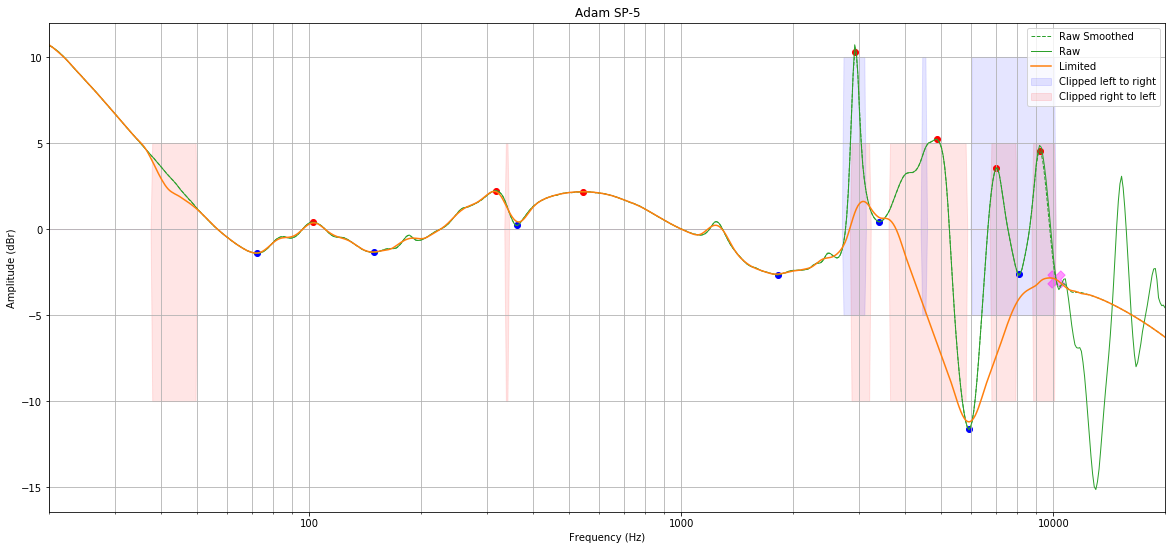

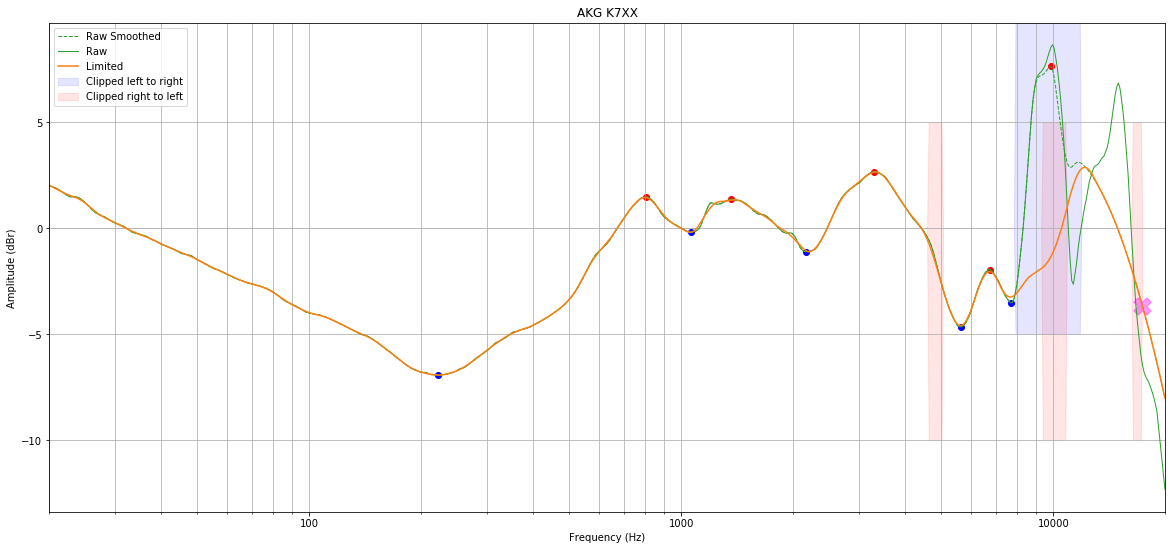

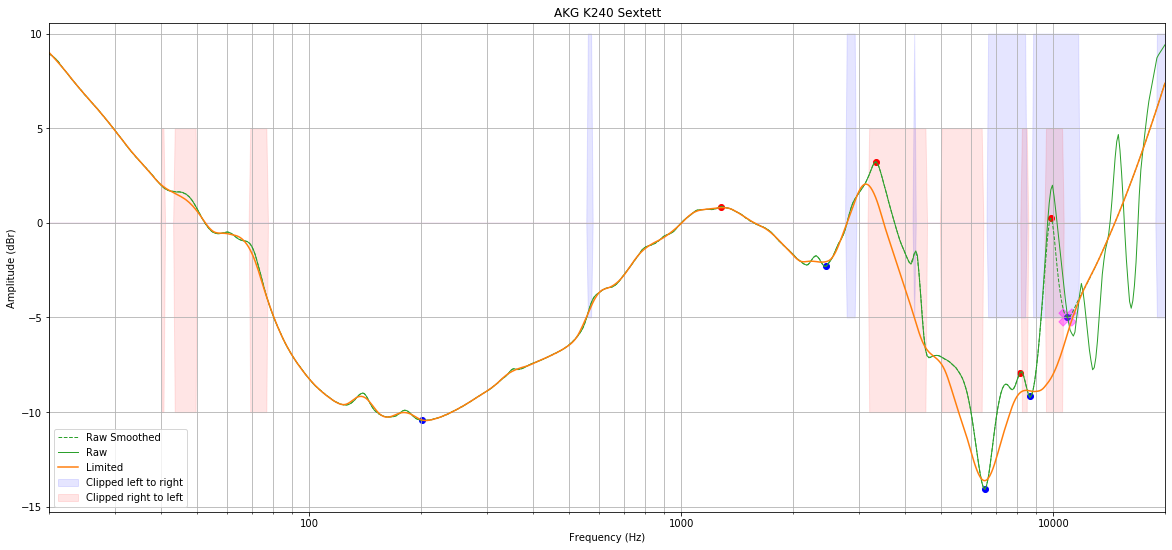

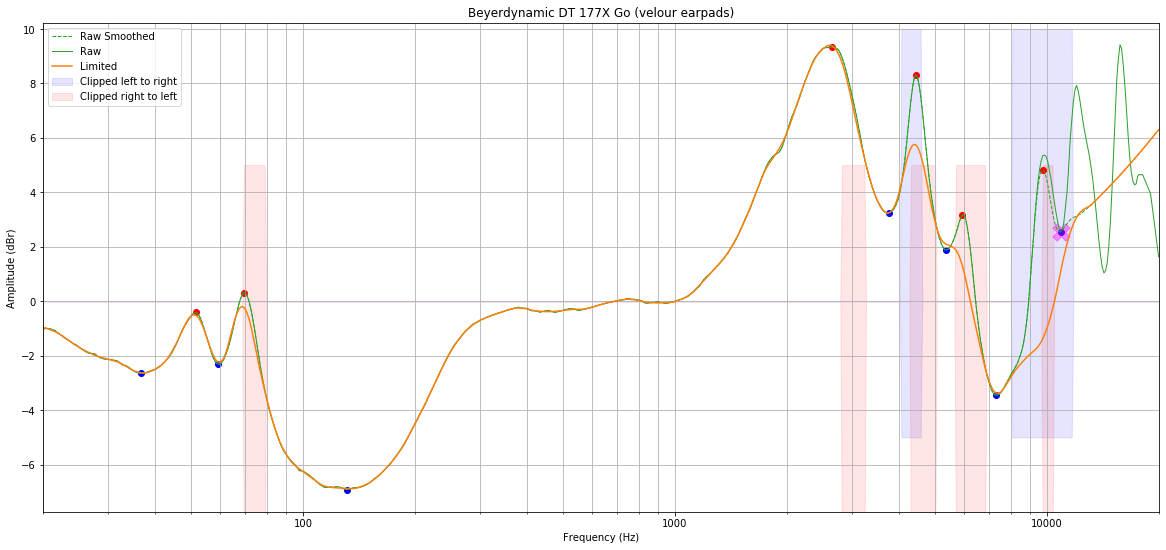

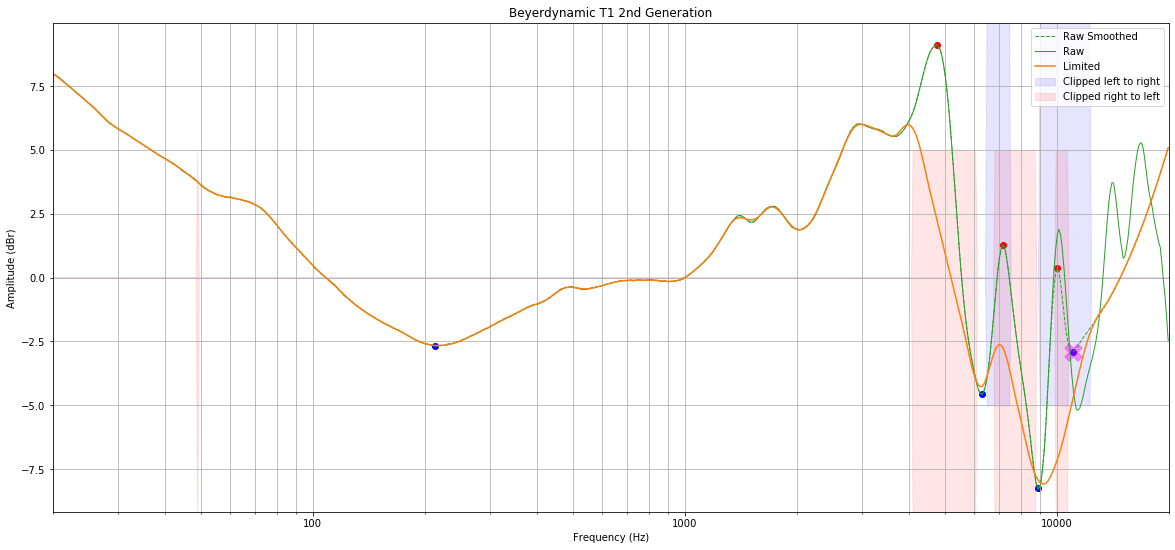

In [12]:
onear_target = ROOT_PATH.joinpath('compensation/harman_over-ear_2018.csv')
inear_target = ROOT_PATH.joinpath('compensation/harman_in-ear_2019v2.csv')

#limited_delta_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/earbud/Apple AirPods/Apple AirPods.csv'), inear_target), 9)

#limited_delta_plots(iir_fr([4000, 4000], [1.0, 4.0], [4.0, -6.0]), 12)

limited_delta_plots(equalization(ROOT_PATH.joinpath('measurements/crinacle/data/inear/1Custom SA02/1Custom SA02.csv'), inear_target), 18)
hd800 = equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Sennheiser HD 800/Sennheiser HD 800.csv'), onear_target)
limited_delta_plots(hd800, 18)

hd800_inverted = hd800.copy()
hd800_inverted.raw *= -1
hd800_inverted.name = 'Sennheiser HD 800 Inverted'
limited_delta_plots(hd800_inverted, 18)

limited_delta_plots(equalization(
    ROOT_PATH.joinpath('measurements/crinacle/data/onear/GRAS 43AG-7/Beyerdynamic DT 770 80 ohm/Beyerdynamic DT 770 80 ohm.csv'), onear_target), 18)
limited_delta_plots(equalization(ROOT_PATH.joinpath('measurements/crinacle/data/inear/Custom Art FIBAE 3/Custom Art FIBAE 3.csv'), inear_target), 18)
limited_delta_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/HIFIMAN Arya/HIFIMAN Arya.csv'), onear_target), 18)

limited_delta_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Adam SP-5/Adam SP-5.csv'), onear_target), 18)  # 4 - 6 kHz
limited_delta_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/AKG K7XX/AKG K7XX.csv'), onear_target), 18)  # 8 - 11 kHz
limited_delta_plots(equalization(ROOT_PATH.joinpath('measurements/oratory1990/data/onear/AKG K240 Sextett/AKG K240 Sextett.csv'), onear_target), 18)  # 4.20 kHz
limited_delta_plots(equalization(
    ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Beyerdynamic DT 177X Go (velour earpads)/Beyerdynamic DT 177X Go (velour earpads).csv'),
    onear_target), 18)  # 6 kHz
limited_delta_plots(equalization(
    ROOT_PATH.joinpath('measurements/oratory1990/data/onear/Beyerdynamic T1 2nd Generation/Beyerdynamic T1 2nd Generation.csv'), onear_target), 18)  # 4.8 kHz

In [113]:
onear_target = ROOT_PATH.joinpath('compensation/harman_over-ear_2018.csv')
for fp in ROOT_PATH.glob('measurements/oratory1990/data/onear/**/*.csv'):
    limited_delta_plots(equalization(fp, onear_target), 18)